In [ ]:
!pip install requests numpy pandas plotly scikit-learn xgboost matplotlib

In [ ]:
import os
import re
import json
import requests
import numpy as np
import pandas as pd
import plotly.express as px
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor

In [ ]:
def get_response(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
                       AppleWebKit/605.1.15 (KHTML, like Gecko) \
                       Chrome/100.0.4896.127 Safari/605.1.15 Firefox/100.0"
    }

    session = requests.Session()
    response = session.get(url, headers=headers)

    return response

In [ ]:
#Scraper Functions
import re

def stock_screener(url):
    #url= "https://www.macrotrends.net/stocks/charts/AAPL/apple/financial-statements"
    url = url
    response = get_response(url).text

    return response
def extract_original_data_line(input_string):
    # Split the input string into lines
    lines = input_string.splitlines()

    # Iterate through each line
    for line in lines:
        # Check if 'var originalData' is in the line
        if "var originalData" in line:
            return line  # Return the entire line if found

    return None  # Return None if not found
def split_by_field_name(input_string):
    return input_string.split('"field_name"')

def extract_value_after_date(input_string, target_date):
    pattern = rf'"{target_date}":"([^"]*)"'
    match = re.search(pattern, input_string)

    if match:
        return match.group(1)
    else:
        return None

def extract_value_after_dateSpecial(input_string, target_date):
    pattern = rf'"{target_date}":([^"]*),'
    match = re.search(pattern, input_string)

    if match:
        return match.group(1)
    else:
        return None

def extract_value_after_dateSpecial2(input_string, target_date):
    pattern = rf'"{target_date}":([^"]*)}}'
    match = re.search(pattern, input_string)

    if match:
        return match.group(1)
    else:
        return None
def RevenueExtractor(filteredData):
  RevenueGrowthList = []
  for i in range(len(filteredData.columns) - 1):
    x = float(filteredData.loc["Revenue"].iloc[i])
    y = float(filteredData.loc["Revenue"].iloc[i + 1])
    RevenueGrowthList.append( ((y-x) / x) * 100)

  RevenueGrowthList.insert(0,0)

  filteredData1 = filteredData.copy()

  filteredData1.loc["Revenue Growth"] = RevenueGrowthList
  return filteredData1

def generate_quarterly_dates(start_year, end_year):
    quarterly_dates = []
    for year in range(start_year, end_year + 1):
        for month in [3, 6, 9, 12]:

            if month == 3:
                date_str = f"{year}-03-31"
            elif month == 6:
                date_str = f"{year}-06-30"
            elif month == 9:
                date_str = f"{year}-09-30"
            elif month == 12:
                date_str = f"{year}-12-31"
            quarterly_dates.append(date_str)
    return quarterly_dates

def remove_curly_brackets(df):
    # Apply a function to each element in the DataFrame
    return df.map(lambda x: x.replace('{', '').replace('}', '') if isinstance(x, str) else x)

In [ ]:
try:
  Aaple_IC = "https://www.macrotrends.net/stocks/charts/AAPL/apple/income-statement?freq=Q"
  Amazon_IC = "https://www.macrotrends.net/stocks/charts/AMZN/amazon/income-statement?freq=Q"
  Alphabet_IC = "https://www.macrotrends.net/stocks/charts/GOOG/alphabet/income-statement?freq=Q"
  Microsoft_IC = "https://www.macrotrends.net/stocks/charts/MSFT/microsoft/income-statement?freq=Q"
  stock_data_IC = stock_screener(Aaple_IC)
  raw_data_IC = split_by_field_name(extract_original_data_line(stock_data_IC))
  del raw_data_IC[0]
except Exception as e:
    print(f"An error occurred: {e}")

try:
  Aaple_CFS = "https://www.macrotrends.net/stocks/charts/AAPL/apple/cash-flow-statement?freq=Q"
  Amazon_CFS = "https://www.macrotrends.net/stocks/charts/AMZN/amazon/cash-flow-statement?freq=Q"
  Alphabet_CFS = "https://www.macrotrends.net/stocks/charts/GOOG/alphabet/cash-flow-statement?freq=Q"
  Microsoft_CFS = "https://www.macrotrends.net/stocks/charts/MSFT/microsoft/cash-flow-statement?freq=Q"
  stock_data_CFS = stock_screener(Aaple_CFS)
  raw_data_CFS = split_by_field_name(extract_original_data_line(stock_data_CFS))
  del raw_data_CFS[0]
  # print(raw_data_CFS)
except Exception as e:
    print(f"An error occurred: {e}")

try:
  Aaple_KFR = "https://www.macrotrends.net/stocks/charts/AAPL/apple/financial-ratios?freq=Q"
  Amazon_KFR = "https://www.macrotrends.net/stocks/charts/AMZN/amazon/financial-ratios?freq=Q"
  Alphabet_KFR = "https://www.macrotrends.net/stocks/charts/GOOG/alphabet/financial-ratios?freq=Q"
  Microsoft_KFR = "https://www.macrotrends.net/stocks/charts/MSFT/microsoft/financial-ratios?freq=Q"
  stock_data_KFR = stock_screener(Aaple_KFR)
  raw_data_KFR = split_by_field_name(extract_original_data_line(stock_data_KFR))
  del raw_data_KFR[0]
  # print(raw_data_KFR)
except Exception as e:
    print(f"An error occurred: {e}")



In [ ]:
#@title Income Statement
import pandas as pd

# Define the lists
Row_Names = [
    "Revenue",
    "Cost of Goods Sold",
    "Gross Profit",
    "R&D Expenses",
    "SG&A Expenses",
    "Other operating income/expenses",
    "Operating expenses",
    "operating income",
    "total non/operating income or expenses",
    "pre-tax income",
    "income expenses",
    "income after taxes",
    "other income",
    "income from continuos operations",
    "income from discontinued operations",
    "Net Income",
    "EBITDA",
    "EBIT",
    "Basic Shares outstanding",
    "Shares outstanding",
    "Basic EPS",
    "EPS"
]

Date_Strings = generate_quarterly_dates(2009, 2024)
Date_Strings.pop()



df_IncomeStatement = pd.DataFrame(columns=Date_Strings, index=Row_Names)
for i in range(len(Row_Names)):
  for j in range(len(Date_Strings)):
    df_IncomeStatement.iat[i, j] = extract_value_after_date(raw_data_IC[i],Date_Strings[j])
#df_IncomeStatement

In [ ]:
#@title Cash Flow Statement

import pandas as pd

Row_Names = [
    "Net Income/Loss",
    "Total Depreciation And Amortization - Cash Flow",
    "Other Non-Cash Items",
    "Total Non-Cash Items",
    "Change In Accounts Receivable",
    "Change In Inventories",
    "Change In Other Current Assets",
    "Change In Accounts/Liabilities",
    "Total Change In Assets/Liabilities",
    "Net Change In Property, Plant, And Equipment",
    "Net Change In Intangible Assets",
    "Net Acquisitions/Divestitures",
    "Net Change In Short-term Investments",
    "Net Change In Long-term Investments",
    "Investing Activities - Other",
    "Net Long-Term Debt",
    "Net Current Debt",
    "Debt Issuance/Retirement Net",
    "Total Equity Issued/Repurchased",
    "Total Equity Issued/Repurchased Stock Dividends Paid",
    "Financial Activities - Other",
    "Net Cash Flow",
    "Stock-Based Compensation",
    "Common Stock Dividends Paid"
]

Date_Strings = generate_quarterly_dates(2009, 2024)
Date_Strings.pop()
# Create a DataFrame with Row_Names as the index and Date_Strings as columns
df_CashFlowStatement = pd.DataFrame(columns=Date_Strings, index=Row_Names)

for i in range(len(Row_Names)):
  for j in range(len(Date_Strings)):
    x = extract_value_after_date(raw_data_CFS[i],Date_Strings[j])
    if x is None or x == "0" or x == "0}":
      #print("runs", Date_Strings[j])
      y = extract_value_after_dateSpecial(raw_data_CFS[i],Date_Strings[j])
      #print(y)
      if y is None or y == "0" or y == "0}":
        df_CashFlowStatement.iat[i, j] = extract_value_after_dateSpecial2(raw_data_CFS[i],Date_Strings[j])
      else:
        df_CashFlowStatement.iat[i, j] = y
    else:
      df_CashFlowStatement.iat[i, j] = x

df_CashFlowStatement = remove_curly_brackets(df_CashFlowStatement)
f = extract_value_after_dateSpecial2(raw_data_CFS[13],"2009-03-31")
if f is None or x == "0" or x == "0}":
  print("true")


In [ ]:
df_CashFlowStatement

,2009-03-31,2009-06-30,2009-09-30,2009-12-31,2010-03-31,2010-06-30,2010-09-30,2010-12-31,2011-03-31,2011-06-30,...,2022-06-30,2022-09-30,2022-12-31,2023-03-31,2023-06-30,2023-09-30,2023-12-31,2024-03-31,2024-06-30,2024-09-30
Net Income/Loss,3875,1828,2532,3378.00000,3074,3253,4308,6004.00000,5987,7308,...,19442,20721,29998.00000,24160,19881,22956,33916.00000,23636,21448,14736
Total Depreciation And Amortization - Cash Flow,349,182,203,209.00000,216,273,329,356.00000,434,481,...,2805,2865,2916.00000,2898,3052,2653,2848.00000,2836,2850,2911
Other Non-Cash Items,929,391,430,630.00000,699,624,366,1122.00000,1027,953,...,3870,589,2588.00000,1271,2698,2049,2008.00000,1982,2876,2556
Total Non-Cash Items,1278,573,633,839.00000,915,897,695,1478.00000,1461,1434,...,6675,3454,5504.00000,4169,5750,4702,4856.00000,4818,5726,5467
Change In Accounts Receivable,490,-754,-675,271.00000,211,-561,-2063,-517.00000,229,-304,...,-981,-6384,4275.00000,5321,-1987,-9297,6555.00000,1172,-1030,-10485
Change In Inventories,197,-68,-75,-121.00000,-62,-304,-109,166.00000,-45,41,...,-16,435,-1807.00000,-741,-22,952,-137.00000,190,-12,-1087
Change In Other Current Assets,-1527,879,740,956.00000,-974,2830,3495,2346.00000,-720,854,...,-4358,15556,-6075.00000,-14689,3974,14901,-4542.00000,-12168,1539,21191
Change In Accounts/Liabilities,466,-188,-45,458.00000,-834,-1314,-643,296.00000,-693,1775,...,2130,-9655,2110.00000,10340,-1216,-12616,-753.00000,5042,1187,-3011
Total Change In Assets/Liabilities,-374,-131,-55,1564.00000,-1659,651,680,2291.00000,-1229,2366,...,-3225,-48,-1497.00000,231,749,-6060,1123.00000,-5764,1684,6608
"Net Change In Property, Plant, And Equipment",4779,2270,3110,5781.00000,2330,4801,5683,9773.00000,6219,11108,...,22892,24127,34005.00000,28560,26380,21598,39895.00000,22690,28858,26811


In [ ]:
#@title Key Financial Ratios

# Define the lists
Row_Names = [
    "Current Ratio",
    "Long-term Debt / Capital",
    "Debt/Equity Ratio",
    "Gross Margin",
    "Operating Margin",
    "EBIT Margin",
    "EBITDA Margin",
    "Pre-Tax Profit Margin",
    "Net Profit Margin",
    "Asset Turnover",
    "Inventory Turnover Ratio",
    "Receivable Turnover",
    "Days Sales In Receivables",
    "ROE - Return On Equity",
    "Return On Tangible Equity",
    "ROA - Return On Assets",
    "ROI - Return On Investments",
    "Book Value Per Share",
    "Operating Cash Flow Per Share",
    "Free Cash Flow Per Share"
]

Date_Strings = generate_quarterly_dates(2009, 2024)
Date_Strings.pop()
# Create a DataFrame with Row_Names as the index and Date_Strings as columns
df_KeyFinancialRatios = pd.DataFrame(columns=Date_Strings, index=Row_Names)

for i in range(len(Row_Names)):
  for j in range(len(Date_Strings)):
    df_KeyFinancialRatios.iat[i, j] = extract_value_after_date(raw_data_KFR[i],Date_Strings[j])


for i in range(len(Row_Names) - 2, len(Row_Names)):
  for j in range(len(Date_Strings)):
    if df_KeyFinancialRatios.iat[i, j] is None:
      df_KeyFinancialRatios.iat[i, j] = extract_value_after_dateSpecial(raw_data_KFR[i],Date_Strings[j])

for i in range(len(Row_Names) - 2, len(Row_Names)):
  for j in range(1):
    df_KeyFinancialRatios.iat[i, j] = extract_value_after_dateSpecial2(raw_data_KFR[i],Date_Strings[j])



df_KeyFinancialRatios

,2009-03-31,2009-06-30,2009-09-30,2009-12-31,2010-03-31,2010-06-30,2010-09-30,2010-12-31,2011-03-31,2011-06-30,...,2022-06-30,2022-09-30,2022-12-31,2023-03-31,2023-06-30,2023-09-30,2023-12-31,2024-03-31,2024-06-30,2024-09-30
Current Ratio,2.46190,2.11090,2.74250,2.54500,2.64420,2.30800,2.01130,1.84610,1.93190,1.74610,...,0.86460,0.87940,0.93800,0.94040,0.98160,0.98800,1.07250,1.03710,0.95300,0.86730
Long-term Debt / Capital,,,,,,,,,,,...,0.61970,0.66140,0.63720,0.60960,0.61940,0.60520,0.56200,0.55310,0.56370,0.60090
Debt/Equity Ratio,,,,,,,,,,,...,2.05980,2.36950,1.95870,1.76350,1.81310,1.78750,1.45800,1.40970,1.51860,1.87230
Gross Margin,39.92740,40.91840,41.82030,40.87870,41.66980,39.08280,36.92670,38.51020,41.42380,41.72760,...,43.25630,42.25920,42.96230,44.26170,44.51630,45.17080,45.87500,46.57810,46.25720,46.22250
Operating Margin,25.57240,27.03930,30.17940,30.12820,29.47630,26.96820,26.77580,29.26970,31.92120,32.82700,...,27.81620,27.61520,30.74240,29.86000,28.11600,30.13360,33.76370,30.74280,29.55570,31.17140
EBIT Margin,25.57240,27.03930,30.17940,30.12820,29.47630,26.96820,26.77580,29.26970,31.92120,32.82700,...,27.81620,27.61520,30.74240,29.86000,28.11600,30.13360,33.76370,30.74280,29.55570,31.17140
EBITDA Margin,,,,,,,,,,,...,,,,,,,,,,
Pre-Tax Profit Margin,26.26600,27.65560,30.54800,30.33860,29.84670,27.33760,26.84460,29.77820,32.02660,33.42900,...,27.80410,27.35230,30.40700,29.92750,27.79200,30.16600,33.72190,30.91690,29.72130,31.19140
Net Profit Margin,17.83360,18.77950,20.74220,21.53930,22.77210,20.71980,21.17680,22.45240,24.27130,25.57840,...,23.43570,22.98610,25.60560,25.47560,24.30530,25.64970,28.36380,26.04430,25.00440,15.52300
Asset Turnover,0.21010,0.20220,0.25700,0.29080,0.23660,0.24260,0.27060,0.30830,0.25990,0.26760,...,0.24670,0.25550,0.33790,0.28550,0.24410,0.25380,0.33820,0.26900,0.25870,0.26010


In [ ]:
import random

combined_df = pd.concat([df_IncomeStatement,df_CashFlowStatement,df_KeyFinancialRatios])

metrics_to_filter = [
    "Current Ratio", "Long-term Debt / Capital", "Debt/Equity Ratio",
    "Gross Margin", "Operating Margin", "Net Profit Margin",
    "ROE - Return On Equity", "ROA - Return On Assets",
    "Operating Cash Flow Per Share", "Free Cash Flow Per Share",
    "R&D Expenses", "SG&A Expenses", "Net Income",
    "EBITDA", "EPS", "Revenue"
]

filteredData = combined_df[combined_df.index.isin(metrics_to_filter)]
filteredData = RevenueExtractor(filteredData)


# combined_df.head(30)

In [ ]:
templist = filteredData.iloc[16].tolist()
len(templist)

def normalize_to_range(numbers):
    min_val = min(numbers)
    max_val = max(numbers)

    # Normalize each number to be between -5 and 5
    normalized_numbers = [
        -5 + ( (x - min_val) / (max_val - min_val) * 10 ) for x in numbers
    ]

    return normalized_numbers



In [ ]:
filteredData

,2009-03-31,2009-06-30,2009-09-30,2009-12-31,2010-03-31,2010-06-30,2010-09-30,2010-12-31,2011-03-31,2011-06-30,...,2022-06-30,2022-09-30,2022-12-31,2023-03-31,2023-06-30,2023-09-30,2023-12-31,2024-03-31,2024-06-30,2024-09-30
Revenue,9084.00000,9734.00000,12207.00000,15683.00000,13499.00000,15700.00000,20343.00000,26741.00000,24667.00000,28571.00000,...,82959.00000,90146.00000,117154.00000,94836.00000,81797.00000,89498.00000,119575.00000,90753.00000,85777.00000,94930.00000
R&D Expenses,319.00000,341.00000,358.00000,398.00000,426.00000,464.00000,494.00000,575.00000,581.00000,628.00000,...,6797.00000,6761.00000,7709.00000,7457.00000,7442.00000,7307.00000,7696.00000,7903.00000,8006.00000,7765.00000
SG&A Expenses,985.00000,1010.00000,1063.00000,1288.00000,1220.00000,1438.00000,1571.00000,1896.00000,1763.00000,1915.00000,...,6012.00000,6440.00000,6607.00000,6201.00000,5973.00000,6151.00000,6786.00000,6468.00000,6320.00000,6523.00000
Net Income,1620.00000,1828.00000,2532.00000,3378.00000,3074.00000,3253.00000,4308.00000,6004.00000,5987.00000,7308.00000,...,19442.00000,20721.00000,29998.00000,24160.00000,19881.00000,22956.00000,33916.00000,23636.00000,21448.00000,14736.00000
EBITDA,2504.00000,2814.00000,3887.00000,4934.00000,4195.00000,4507.00000,5776.00000,8183.00000,8308.00000,9860.00000,...,25881.00000,27759.00000,38932.00000,31216.00000,26050.00000,29622.00000,43221.00000,30736.00000,28202.00000,32502.00000
EPS,0.06390,0.07180,0.09930,0.13110,0.11890,0.12540,0.16570,0.22960,0.22860,0.27820,...,1.20000,1.29000,1.88000,1.52000,1.26000,1.47000,2.18000,1.53000,1.40000,0.97000
Current Ratio,2.46190,2.11090,2.74250,2.54500,2.64420,2.30800,2.01130,1.84610,1.93190,1.74610,...,0.86460,0.87940,0.93800,0.94040,0.98160,0.98800,1.07250,1.03710,0.95300,0.86730
Long-term Debt / Capital,,,,,,,,,,,...,0.61970,0.66140,0.63720,0.60960,0.61940,0.60520,0.56200,0.55310,0.56370,0.60090
Debt/Equity Ratio,,,,,,,,,,,...,2.05980,2.36950,1.95870,1.76350,1.81310,1.78750,1.45800,1.40970,1.51860,1.87230
Gross Margin,39.92740,40.91840,41.82030,40.87870,41.66980,39.08280,36.92670,38.51020,41.42380,41.72760,...,43.25630,42.25920,42.96230,44.26170,44.51630,45.17080,45.87500,46.57810,46.25720,46.22250


In [ ]:
#@title LinearRegression

from sklearn.model_selection import cross_val_score


filteredData = filteredData.apply(pd.to_numeric, errors='coerce')

data = filteredData.transpose()

data = data.ffill()
data['Revenue Growth'] = data['Revenue'].pct_change(periods=1) * 100

data = data.dropna(subset=['Revenue Growth'])

selected_features = [
    "Current Ratio",
    "Long-term Debt / Capital",
    "Debt/Equity Ratio",
    "Gross Margin",
    "Operating Margin",
    "Net Profit Margin",
    "ROE - Return On Equity",
    "ROA - Return On Assets",
    "Operating Cash Flow Per Share",
    "Free Cash Flow Per Share",
    "R&D Expenses",
    "SG&A Expenses",
    "Net Income",
    "EBITDA",
    "EPS",
    "Revenue"
]

data = data[selected_features + ['Revenue Growth']]

lag_features = ["Revenue", "Gross Margin", "Operating Margin", "Net Profit Margin"]
for feature in lag_features:
    data[f'{feature}_lag1'] = data[feature].shift(1)
    data[f'{feature}_lag2'] = data[feature].shift(2)

data = data.dropna()

X = data.drop(columns=['Revenue Growth'])
y = data['Revenue Growth']

X_train = X.loc['2009-09-30':'2015-09-30']
y_train = y.loc['2009-09-30':'2015-09-30']

X_test = X.loc['2016-09-30':'2020-09-30']
y_test = y.loc['2016-09-30':'2020-09-30']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("Model Evaluation:")
print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train R²: {train_r2:.2f}, Test R²: {test_r2:.2f}")

coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)


int(filteredData.loc["Current Ratio"].iloc[7])
date = 20
future_data = {
    "Current Ratio": [int(filteredData.loc["Current Ratio"].iloc[date])],
    "Long-term Debt / Capital": [int(filteredData.loc["Long-term Debt / Capital"].iloc[date])],
    "Debt/Equity Ratio": [int(filteredData.loc["Debt/Equity Ratio"].iloc[date])],
    "Gross Margin": [int(filteredData.loc["Gross Margin"].iloc[date])],
    "Operating Margin": [int(filteredData.loc["Operating Margin"].iloc[date])],
    "Net Profit Margin": [int(filteredData.loc["Net Profit Margin"].iloc[date])],
    "ROE - Return On Equity": [int(filteredData.loc["ROE - Return On Equity"].iloc[date])],
    "ROA - Return On Assets": [int(filteredData.loc["ROA - Return On Assets"].iloc[date])],
    "Operating Cash Flow Per Share": [int(filteredData.loc["Operating Cash Flow Per Share"].iloc[date])],
    "Free Cash Flow Per Share": [int(filteredData.loc["Free Cash Flow Per Share"].iloc[date])],
    "R&D Expenses": [int(filteredData.loc["R&D Expenses"].iloc[date])],
    "SG&A Expenses": [int(filteredData.loc["SG&A Expenses"].iloc[date])],
    "Net Income": [int(filteredData.loc["Net Income"].iloc[date])],
    "EBITDA": [int(filteredData.loc["EBITDA"].iloc[date])],
    "EPS": [int(filteredData.loc["EPS"].iloc[date])],
    "Revenue": [int(filteredData.loc["Revenue"].iloc[date])],
    "Revenue_lag1": [int(filteredData.loc["Revenue"].iloc[date])],
    "Revenue_lag2": [int(filteredData.loc["Revenue"].iloc[date])],
    "Gross Margin_lag1": [int(filteredData.loc["Gross Margin"].iloc[date])],
    "Gross Margin_lag2": [int(filteredData.loc["Gross Margin"].iloc[date])],
    "Operating Margin_lag1": [int(filteredData.loc["Operating Margin"].iloc[date])],
    "Operating Margin_lag2": [int(filteredData.loc["Operating Margin"].iloc[date])],
    "Net Profit Margin_lag1": [int(filteredData.loc["Net Profit Margin"].iloc[date])],
    "Net Profit Margin_lag2": [int(filteredData.loc["Net Profit Margin"].iloc[date])],
}

future_df = pd.DataFrame(future_data)

future_scaled = scaler.transform(future_df)

predicted_growth = model.predict(future_scaled)


print(predicted_growth[0])


Model Evaluation:
Train MAE: 0.00, Test MAE: 65.30
Train RMSE: 0.00, Test RMSE: 70.65
Train R²: 1.00, Test R²: -3.95
-43.20126872600892


In [ ]:
#@title XGBOOSTCODE

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
# x = 0.1
# def XGBoost(EarlyStop, Date, filteredData):
# tempni = 0
# for i in range(100):
filteredData = filteredData.apply(pd.to_numeric, errors='coerce')
data = filteredData.transpose()
data = data.ffill()
data['Revenue Growth'] = data['Revenue'].pct_change(periods=1) * 100
data = data.dropna(subset=['Revenue Growth'])
selected_features = [
    "Current Ratio",
    "Long-term Debt / Capital",
    "Debt/Equity Ratio",
    "Gross Margin",
    "Operating Margin",
    "Net Profit Margin",
    "ROE - Return On Equity",
    "ROA - Return On Assets",
    "Operating Cash Flow Per Share",
    "Free Cash Flow Per Share",
    "R&D Expenses",
    "SG&A Expenses",
    "Net Income",
    "EBITDA",
    "EPS",
    "Revenue",
    "Sentiment Analysis"
]

data = data[selected_features + ['Revenue Growth']]

lag_features = ["Revenue", "Gross Margin", "Operating Margin", "Net Profit Margin"]
for feature in lag_features:
    data[f'{feature}_lag1'] = data[feature].shift(1)


data = data.dropna()

X = data.drop(columns=['Revenue Growth'])
y = data['Revenue Growth']

X_train = X.loc['2009-03-31':'2023-03-31']
y_train = y.loc['2009-03-31':'2023-03-31']

X_test = X.loc['2023-04-31':'2024-12-31']
y_test = y.loc['2023-04-31':'2024-12-31']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

xgb_model = xgb.XGBRegressor(
    n_estimators=11,      # Number of trees
    learning_rate=0.06,     # Step size shrinkage
    max_depth=9,            # Maximum depth of trees
    subsample=0.8,          # Subsample ratio for training instances
    colsample_bytree=0.8,   # Subsample ratio of columns when constructing each tree
    random_state = 55,        # Set random seed for reproducibility 40
    objective='reg:squarederror',  # Objective for regression tasks
    eval_metric='rmse',  # Evaluation metric for early stopping
    # early_stopping_rounds = 1001
)

# Fit the model with early stopping
xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],  # Validation set for early stopping
    # early_stopping_rounds=50,  # Stop if validation error doesn't improve for 50 rounds
    verbose=False  # Print progress during training
)

y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("XGBoost Model Evaluation:")
print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train R²: {train_r2:.2f}, Test R²: {test_r2:.2f}")

importance = xgb_model.feature_importances_
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:")
print(feature_importance)


XGBoost Model Evaluation:
Train MAE: 15.17, Test MAE: 11.59
Train RMSE: 19.02, Test RMSE: 13.98
Train R²: 0.65, Test R²: 0.45

Feature Importance:
                          Feature  Importance
8   Operating Cash Flow Per Share    0.229485
9        Free Cash Flow Per Share    0.203909
12                     Net Income    0.138199
18              Gross Margin_lag1    0.094325
16             Sentiment Analysis    0.090281
20         Net Profit Margin_lag1    0.076316
7          ROA - Return On Assets    0.057535
11                  SG&A Expenses    0.048775
1        Long-term Debt / Capital    0.018886
17                   Revenue_lag1    0.011792
4                Operating Margin    0.009997
15                        Revenue    0.006805
5               Net Profit Margin    0.006636
3                    Gross Margin    0.005312
0                   Current Ratio    0.001453
13                         EBITDA    0.000295
14                            EPS    0.000000
6          ROE - Return O

In [ ]:
def XGBoostPredictions(date):
  future_inputs = pd.DataFrame({
      "Current Ratio": [int(filteredData.loc["Current Ratio"].iloc[date])],
      "Long-term Debt / Capital": [int(filteredData.loc["Long-term Debt / Capital"].iloc[date])],
      "Debt/Equity Ratio": [int(filteredData.loc["Debt/Equity Ratio"].iloc[date])],
      "Gross Margin": [int(filteredData.loc["Gross Margin"].iloc[date])],
      "Operating Margin": [int(filteredData.loc["Operating Margin"].iloc[date])],
      "Net Profit Margin": [int(filteredData.loc["Net Profit Margin"].iloc[date])],
      "ROE - Return On Equity": [int(filteredData.loc["ROE - Return On Equity"].iloc[date])],
      "ROA - Return On Assets": [int(filteredData.loc["ROA - Return On Assets"].iloc[date])],
      "Operating Cash Flow Per Share": [int(filteredData.loc["Operating Cash Flow Per Share"].iloc[date])],
      "Free Cash Flow Per Share": [int(filteredData.loc["Free Cash Flow Per Share"].iloc[date])],
      "R&D Expenses": [int(filteredData.loc["R&D Expenses"].iloc[date])],
      "SG&A Expenses": [int(filteredData.loc["SG&A Expenses"].iloc[date])],
      "Net Income": [int(filteredData.loc["Net Income"].iloc[date])],
      "EBITDA": [int(filteredData.loc["EBITDA"].iloc[date])],
      "EPS": [int(filteredData.loc["EPS"].iloc[date])],
      "Revenue": [int(filteredData.loc["Revenue"].iloc[date])],
      "Sentiment Analysis": [int(filteredData.loc["Sentiment Analysis"].iloc[date])],
      "Revenue_lag1": [int(filteredData.loc["Revenue"].iloc[date])],
    # "Revenue_lag2": [int(filteredData.loc["Revenue"].iloc[date])],
      "Gross Margin_lag1": [int(filteredData.loc["Gross Margin"].iloc[date])],
    # "Gross Margin_lag2": [int(filteredData.loc["Gross Margin"].iloc[date])],
      "Operating Margin_lag1": [int(filteredData.loc["Operating Margin"].iloc[date])],
      #"Operating Margin_lag2": [int(filteredData.loc["Operating Margin"].iloc[date])],
      "Net Profit Margin_lag1": [int(filteredData.loc["Net Profit Margin"].iloc[date])],
      #"Net Profit Margin_lag2": [int(filteredData.loc["Net Profit Margin"].iloc[date])],
  })

  future_inputs_scaled = scaler.transform(future_inputs)

  future_prediction = xgb_model.predict(future_inputs_scaled)
  return future_prediction[0]

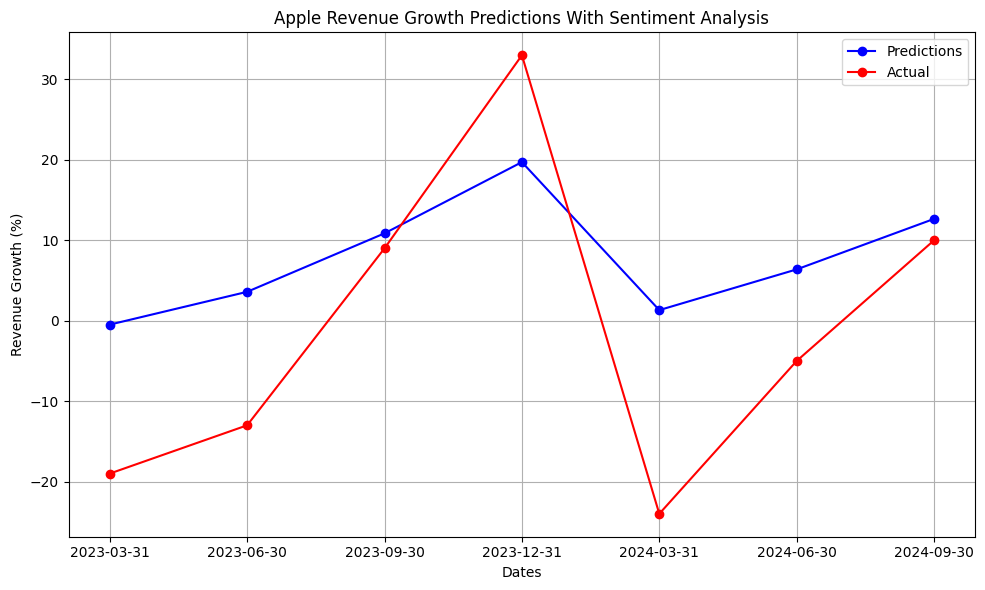

In [ ]:
import matplotlib.pyplot as plt



labels = []
list1 = []
list2 = []
for i in range(56,63):
  labels.append(Date_Strings[i])
  list1.append(XGBoostPredictions(i))
  list2.append(int(filteredData.iloc[16].loc[Date_Strings[i]]))

plt.figure(figsize=(10, 6))

plt.plot(labels, list1, marker='o', linestyle='-', color='b', label='Predictions')
plt.plot(labels, list2, marker='o', linestyle='-', color='r', label='Actual')

plt.title('Apple Revenue Growth Predictions With Sentiment Analysis')
plt.xlabel('Dates')
plt.ylabel('Revenue Growth (%)')

plt.legend()

plt.grid()

plt.tight_layout()
plt.show()